### Cell 1 : Imports & TARGET selection

In [116]:
# === Cell 1 : Imports & TARGET selection ====================================
import os, re
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ---------------------------------------------------------------------------
# Configuration – **edit these if your folder layout changes**
# ---------------------------------------------------------------------------
ARRIVAL_DIR = Path(r"C:\Users\samih\OneDrive - Imperial College London\Year 4\FYP\Sami Haque\Technical\Modding\Computer-Vision-for-Fire-Mod")
AVERAGE_OUTDIR = ARRIVAL_DIR / "AVERAGED Arrival Matrices"
AVERAGE_OUTDIR.mkdir(exist_ok=True, parents=True)

TARGETS = [
    # r"Sorted Arrival Matrices\QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves",
    # r"Sorted Arrival Matrices\QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves - V4 Remove Adj MaxAge Fire",
    # r"Sorted Arrival Matrices\Green Leaves - V4 Remove Adj MaxAge Fire",
    # r"Sorted Arrival Matrices\Green Wool = Leaves",
    r"Sorted Arrival Matrices\Sample 100% Spread Chance",
]

# ---------------------------------------------------------------------------
# Heat‑map colour‑bar control
# ---------------------------------------------------------------------------
FIXED_CBAR = False   # False → auto scale
CBAR_MIN   = 0
CBAR_MAX   = 200

TIME_INTERVAL = 10
COMPUTE_AVERAGE = True
SAVE_AVERAGE    = True
SHOW_ORIGINALS  = True
AVERAGE_NAME    = "Average"

# ── helper to expand TARGETS into concrete file list ────────────────────────

def _natural_key(text: str):
    return [int(num) if num.isdigit() else num.lower() for num in re.split(r"(\d+)", text)]

def gather_matrix_files(root: Path, targets):
    files = []
    for entry in targets:
        p = (root / entry).resolve()
        if p.is_file():
            files.append(p)
        elif p.is_dir():
            files.extend(p.glob("*.npy"))
        else:
            print("⚠️  Not found:", p)
    files = sorted(files, key=lambda path: _natural_key(path.name))
    return [str(f.relative_to(root)) for f in files]

MATRIX_FILES = gather_matrix_files(ARRIVAL_DIR, TARGETS)
print(f"Found {len(MATRIX_FILES)} matrix file(s):")
for f in MATRIX_FILES:
    print(" •", f)


Found 1 matrix file(s):
 • Sorted Arrival Matrices\Sample 100% Spread Chance\34 x 34--Sample 100% Spread Chance arrival.npy


### Cell 2 : Helper functions

In [117]:
# === Cell 2 : Helper functions =============================================
PURPLE, GREEN, PINK          = (178,  69, 208), (  0,255,  0), (255,192,203)
LIGHTBLUE, DARKGREEN, WHITE = (173,216,230), (  0, 90,  0), (255,255,255)

def _quad_rgb(y, x, h, w, mode):
    top, left = y < h//2, x < w//2
    if mode == "quadrants-4":
        return (PURPLE if  top and  left else GREEN if  top and not left else
                PINK   if not top and  left else LIGHTBLUE)
    if mode == "quadrants-3":
        return PURPLE if left else GREEN if top and not left else LIGHTBLUE
    if mode == "quadrants-2":
        return PURPLE if left else GREEN
    if mode == "quadrants-1":
        return DARKGREEN
    return WHITE


def plot_arrival_heatmap_with_isochrones(arr, cmap="hot", time_interval=TIME_INTERVAL,
                                         *, unburnt_style="white", show_heatmap=True,
                                         show_isochrones=True, add_quadrant=True,
                                         caption=""):
    """Plot with centre (0,0) coordinate system and fixed tick labels."""
    data = arr[1:-1, 1:-1]
    h, w = data.shape
    cx, cy = w // 2, h // 2  # centre index
    finite = np.isfinite(data)

    # ----- colour‑bar limits ---------------------------------------------
    if FIXED_CBAR and show_heatmap:
        t_min, t_max = CBAR_MIN, CBAR_MAX
    else:
        t_min, t_max = np.nanmin(data), np.nanmax(data)

    # ----- RGB canvas -----------------------------------------------------
    rgb = np.full((h, w, 3), WHITE, np.uint8)
    if show_heatmap:
        norm = np.clip((data - t_min) / (t_max - t_min), 0, 1)
        heat = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)
        rgb[finite] = heat[finite]

    if unburnt_style != "white":
        ys, xs = np.where(~finite)
        for y, x in zip(ys, xs):
            rgb[y, x] = _quad_rgb(y, x, h, w, unburnt_style)

    # ----- contour prep ----------------------------------------------------
    sentinel = t_max + time_interval
    filled   = np.nan_to_num(data, nan=sentinel)
    base_t   = CBAR_MIN if FIXED_CBAR else t_min
    first    = (np.floor(base_t/time_interval)+1)*time_interval
    levels   = np.arange(first, t_max+time_interval, time_interval)

    # ----- plot ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rgb, interpolation="nearest", origin="upper")

    # ensure full matrix visible
    ax.set_xlim(-0.5, w-0.5)
    ax.set_ylim(h-0.5, -0.5)

            # ----- customise ticks (edges): −16, −12, …, 16 -----------------------
    desired = np.arange(-16, 17, 4)
    x_pos = cx + desired - 0.5  # shift to cell edges
    y_pos = cy - desired - 0.5
    in_x  = (-0.5 <= x_pos) & (x_pos <= w-0.5)
    in_y  = (-0.5 <= y_pos) & (y_pos <= h-0.5)
    ax.set_xticks(x_pos[in_x]); ax.set_xticklabels(desired[in_x])
    ax.set_yticks(y_pos[in_y]); ax.set_yticklabels(desired[in_y])

    if show_heatmap:
        sm = plt.cm.ScalarMappable(cmap=cmap,
                                   norm=plt.Normalize(vmin=t_min, vmax=t_max))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("Arrival Time (sec)")

    if show_isochrones:
        cs = ax.contour(filled, levels=levels, colors="blue", linewidths=1)
        ax.clabel(cs, fmt=lambda v: f"{int(v)} s", inline=True, fontsize=8)

    if add_quadrant:
        ax.axvline(cx-0.5, color="black", ls="--")
        ax.axhline(cy-0.5, color="black", ls="--")

    plt.tight_layout()
    plt.show()
    if caption:
        print(caption)

### Cell 3 : Process list, optional average, and plot

💾 saved averaged matrix -> C:\Users\samih\OneDrive - Imperial College London\Year 4\FYP\Sami Haque\Technical\Modding\Computer-Vision-for-Fire-Mod\AVERAGED Arrival Matrices\34 x 34--Sample 100% Spread Chance arrival average of 1, 10s interval.npy


C:\Users\samih\AppData\Local\Temp\ipykernel_22484\100946418.py:12: RuntimeWarning: Mean of empty slice
  mean_mat = np.nanmean(np.stack(loaded, axis=0), axis=0)
C:\Users\samih\AppData\Local\Temp\ipykernel_22484\2148525911.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heat = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)


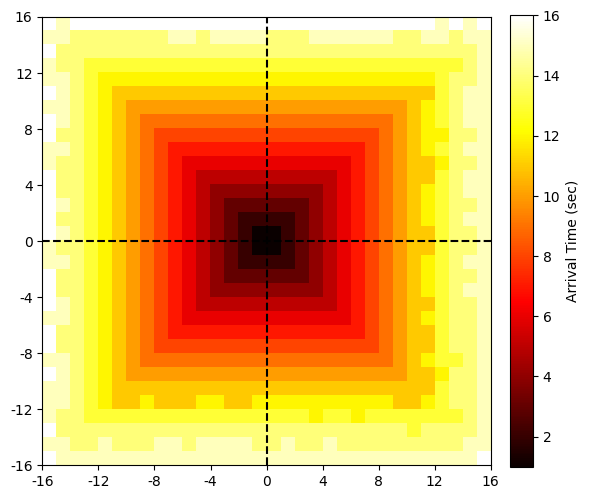

Average of 1 matrices | Heat‑Map


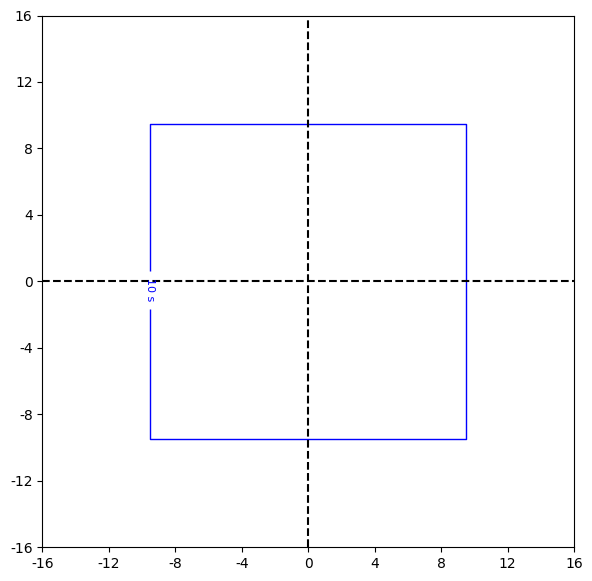

Average of 1 matrices | Isochrones — 10s spacing


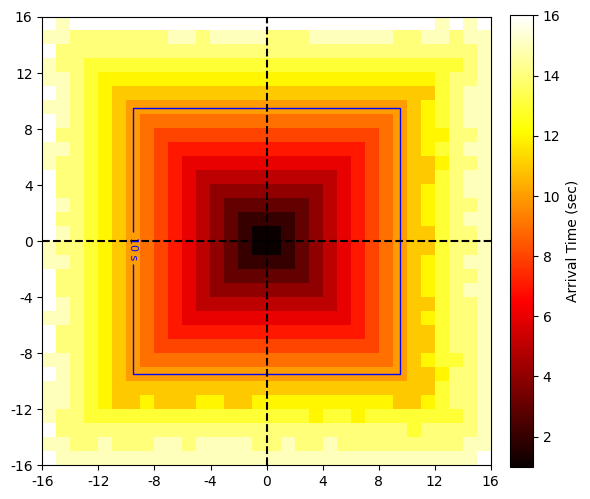

Average of 1 matrices | Heat‑Map & Isochrones — 10s spacing


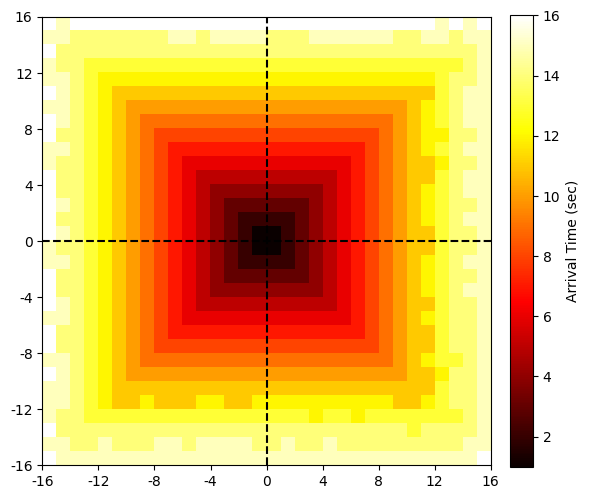

34 x 34--Sample 100% Spread Chance arrival | Heat‑Map


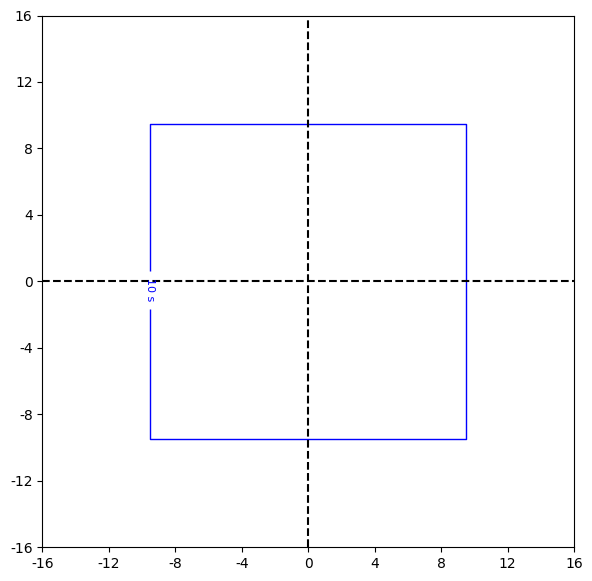

34 x 34--Sample 100% Spread Chance arrival | Isochrones — 10s spacing


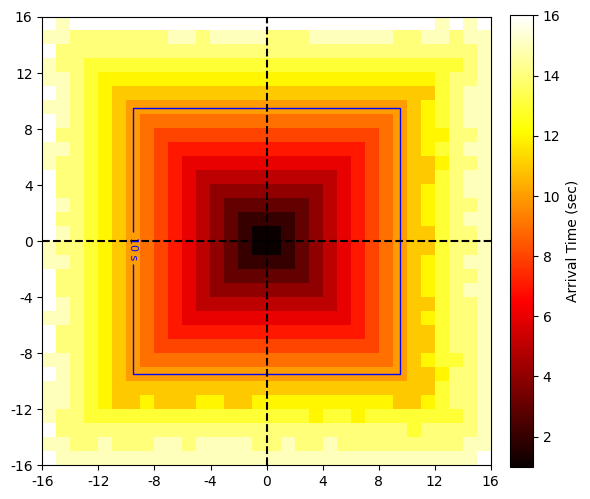

34 x 34--Sample 100% Spread Chance arrival | Heat‑Map & Isochrones — 10s spacing


In [118]:
# === Cell 3 : Process list, optional average, and plot =====================
loaded   = []
base_ids = []

for fname in MATRIX_FILES:
    path = ARRIVAL_DIR / fname  # absolute Path
    loaded.append(np.load(path))
    base_ids.append(Path(fname).stem)  # filename stem (no directories)

# ---------- average block --------------------------------------------------
if COMPUTE_AVERAGE and loaded:
    mean_mat = np.nanmean(np.stack(loaded, axis=0), axis=0)
    n_loaded = len(loaded)

    if SAVE_AVERAGE:
        first_stem = base_ids[0]                      # e.g. "34 x 34--Green …"
        prefix = re.sub(r"--v\d+\s+arrival$", "", first_stem)
        avg_fname = f"{prefix} average of {n_loaded}, {TIME_INTERVAL}s interval.npy"
        avg_path  = AVERAGE_OUTDIR / avg_fname
        avg_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(avg_path, mean_mat)
        print("💾 saved averaged matrix ->", avg_path)

    # --- average visualisations (all three variants) ----------------------
    # heat‑map only
    plot_arrival_heatmap_with_isochrones(
        mean_mat,
        unburnt_style="quadrants-4",
        show_heatmap=True,
        show_isochrones=False,
        caption=(f"{AVERAGE_NAME} of {n_loaded} matrices | Heat‑Map")
    )
    # contours only
    plot_arrival_heatmap_with_isochrones(
        mean_mat,
        unburnt_style="white",
        show_heatmap=False,
        show_isochrones=True,
        caption=(f"{AVERAGE_NAME} of {n_loaded} matrices | Isochrones — "
                 f"{TIME_INTERVAL}s spacing")
    )
    # combined
    plot_arrival_heatmap_with_isochrones(
        mean_mat,
        unburnt_style="quadrants-4",
        show_heatmap=True,
        show_isochrones=True,
        caption=(f"{AVERAGE_NAME} of {n_loaded} matrices | Heat‑Map & Isochrones — "
                 f"{TIME_INTERVAL}s spacing")
    )

# ---------- individual runs ------------------------------------------------
if SHOW_ORIGINALS:
    for mat, stem in zip(loaded, base_ids):
        nice_name = Path(stem).name
        # heat‑map only
        plot_arrival_heatmap_with_isochrones(
            mat,
            unburnt_style="quadrants-1",
            show_heatmap=True,
            show_isochrones=False,
            caption=f"{nice_name} | Heat‑Map"
        )
        # contours only
        plot_arrival_heatmap_with_isochrones(
            mat,
            unburnt_style="white",
            show_heatmap=False,
            show_isochrones=True,
            caption=f"{nice_name} | Isochrones — {TIME_INTERVAL}s spacing"
        )
        # combined
        plot_arrival_heatmap_with_isochrones(
            mat,
            unburnt_style="quadrants-1",
            show_heatmap=True,
            show_isochrones=True,
            caption=f"{nice_name} | Heat‑Map & Isochrones — {TIME_INTERVAL}s spacing"
        )

